## Hackathon 3 : Sentiment Classification

<b>Problem Statement</b>
<p>Twitter has now become a useful way to build one's business as it helps in giving the brand a voice and a personality. The platform is also a quick, easy and inexpensive way to gain valuable insight from the desired audience. Identifying the sentiments about the product/brand can help the business take better actions.</p>

You have with you evaluated tweets about multiple brands. The evaluators(random audience) were asked if the tweet expressed positive, negative, or no emotion towards a product/brand and labelled accordingly.

<b>Dataset Description</b> 
<p>This dataset contains around 7k tweet text with the sentiment label.

The file train.csv has 3 columns

tweet_id - Unique id for tweets. tweet - Tweet about the brand/product sentiment - 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell </p>

<b>Evaluation Metric</b> 
<p> We will be using ‘weighted’ F1-measure as the evaluation metric for this competition. For more information on the F1-metric refer to https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html  </p>

<b>Submission format</b> 
<p> Submission file should have two columns, one for tweet_id and sencond for sentiment [0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell]. A sample submission file has also been attached for reference. </p>

## Start of Notebook

#### Why are we doing this
- To Classify the Tweets into positive , neutral , negative, Cant tell
- To Identify sentiments of product/brand

#### Stakeholders:
- Customer of Withwicky 
- DataScience head or Project Manager of WithWicky

In [133]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from html.parser import HTMLParser
from textblob import TextBlob
import string
from spellchecker import SpellChecker
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from autocorrect import Speller
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.model_selection import GridSearchCV

import plotly.offline as pyo
from plotly import graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()

#### Import DataSet

In [134]:
traindf = pd.read_csv("train.csv")
#testdf = pd.read_csv("test.csv")

In [135]:
traindf.dtypes

tweet_id      int64
tweet        object
sentiment     int64
dtype: object

## EDA

#### Checking Train DataSet

In [136]:
traindf.head()

tweet_id                                              tweet  sentiment
0      1701  #sxswnui #sxsw #apple defining language of tou...          1
1      1851  Learning ab Google doodles! All doodles should...          1
2      2689  one of the most in-your-face ex. of stealing t...          2
3      4525  This iPhone #SXSW app would b pretty awesome i...          0
4      3604  Line outside the Apple store in Austin waiting...          1

tweets_text = traindf.tweet.str.cat()
emos = set(re.findall(r" ([xX:;][-']?.) ",tweets_text))
emos_count = []
for emo in emos:
    emos_count.append((tweets_text.count(emo), emo))
sorted(emos_count,reverse=True)

HAPPY_EMO = r" ([xX;:]-?[dD)]|:-?[\)]|[;:][pP]) "
SAD_EMO = r" (:'?[/|\(]) "
print("Happy emoticons:", set(re.findall(HAPPY_EMO, tweets_text)))
print("Sad emoticons:", set(re.findall(SAD_EMO, tweets_text)))

In [137]:
temp = traindf.groupby('sentiment').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)

In [138]:
temp

sentiment  tweet
1          1   4310
2          2   2382
0          0    456
3          3    125

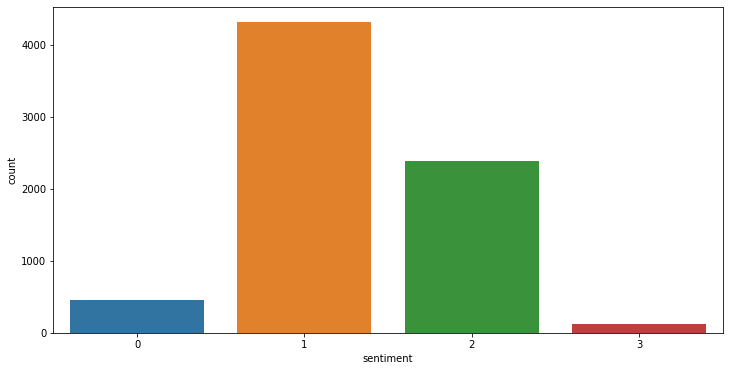

In [139]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=traindf)

In [140]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.tweet,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))

fig.show()

In [141]:
traindf.info

<bound method DataFrame.info of       tweet_id                                              tweet  sentiment
0         1701  #sxswnui #sxsw #apple defining language of tou...          1
1         1851  Learning ab Google doodles! All doodles should...          1
2         2689  one of the most in-your-face ex. of stealing t...          2
3         4525  This iPhone #SXSW app would b pretty awesome i...          0
4         3604  Line outside the Apple store in Austin waiting...          1
...        ...                                                ...        ...
7269      3343  @mention Google plze Tammi.  I'm in middle of ...          1
7270      5334  RT @mention ÷¼ Are you all set? ÷_ {link} ÷...          1
7271      5378  RT @mention Aha! Found proof of lactation room...          1
7272      2173  We just launched our iPad app at #SXSW! Get al...          1
7273      3162  The next fin serv battle is vs Apple, GOOG, Mo...          1

[7274 rows x 3 columns]>

In [142]:
traindf.dtypes

tweet_id      int64
tweet        object
sentiment     int64
dtype: object

In [143]:
traindf.head()


tweet_id                                              tweet  sentiment
0      1701  #sxswnui #sxsw #apple defining language of tou...          1
1      1851  Learning ab Google doodles! All doodles should...          1
2      2689  one of the most in-your-face ex. of stealing t...          2
3      4525  This iPhone #SXSW app would b pretty awesome i...          0
4      3604  Line outside the Apple store in Austin waiting...          1

In [144]:
traindf.info

<bound method DataFrame.info of       tweet_id                                              tweet  sentiment
0         1701  #sxswnui #sxsw #apple defining language of tou...          1
1         1851  Learning ab Google doodles! All doodles should...          1
2         2689  one of the most in-your-face ex. of stealing t...          2
3         4525  This iPhone #SXSW app would b pretty awesome i...          0
4         3604  Line outside the Apple store in Austin waiting...          1
...        ...                                                ...        ...
7269      3343  @mention Google plze Tammi.  I'm in middle of ...          1
7270      5334  RT @mention ÷¼ Are you all set? ÷_ {link} ÷...          1
7271      5378  RT @mention Aha! Found proof of lactation room...          1
7272      2173  We just launched our iPad app at #SXSW! Get al...          1
7273      3162  The next fin serv battle is vs Apple, GOOG, Mo...          1

[7274 rows x 3 columns]>

## Stop Words Removal

stopwords.words('english')


In [145]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#### Data Cleaning

In [146]:
# Function for converting emoticons into word
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', " ".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

In [147]:
convert_emoticons("Awwww yeah!!! RT @mention Congrats to @mention on winning the last @mention #iPad case for her boyfriend aw :) #SXSW #cbatsxsw")

'Awwww yeah!!! RT @mention Congrats to @mention on winning the last @mention #iPad case for her boyfriend aw Happy face or smiley #SXSW #cbatsxsw'

In [148]:
traindf.tweet[220]

'Awwww yeah!!! RT @mention Congrats to @mention on winning the last @mention #iPad case for her boyfriend aw :) #SXSW #cbatsxsw'

In [149]:
def dataCleaning(df,stemming = False, lemmatization=False):
    html_parser = HTMLParser()
    
    # convert column type to string
    df['tweet'] = df['tweet'].astype(str)
    
    
    # to lower case
    df['tweet'] = df['tweet'].apply(lambda x: x.lower())
    
    #stopword removal  , removed NOT from STOP-WORDS
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    stop_words = all_stopwords
    traindf['tweet'] =  traindf['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    #removing @mention
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(@[mention]+)',' ',x))
    
    #removing @handles , since trending tweets are on Hashtags
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(@[A-Za-z0-9]+)',' ',x))
    
     #removing Http links , since trending tweets are on Hashtags
    df['tweet']= df['tweet'].apply(lambda x: re.sub('http\S+',' ',x))
    
    #converting emoticon
    df['tweet']= df['tweet'].apply(lambda x: convert_emoticons(x))
    
    # remove numbers
    df['tweet']= df['tweet'].apply(lambda x: re.sub(r'\d+', ' ', x))
    

    # remove punctuations and convert characters to lower case
    df['tweet'] = df['tweet'].apply(lambda x: "".join([char.lower() for char in x if char not in string.punctuation]))
    
    #converting Html Encoding
    
    df['tweet']= df['tweet'].apply(lambda x: html_parser.unescape(x))
    
    #removing #HashTags 
    #df['tweet']= df['tweet'].apply(lambda x: re.sub('(#[A-Za-x0-9\\_\\]+)',' ',x))
    
    # #removing '#' symbol 
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(#+)',' ',x))
     
    
    #replacing double whitespace with single 
    df['tweet']= df['tweet'].apply(lambda x: re.sub(' +', ' ',x))
    
    #Removing RT
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(rt)\W', ' ',x))
    
    if stemming:
        st = SnowballStemmer('english')
        df['tweet'] = df['tweet'].apply(lambda x: " ".join([st.stem(w) for w in x.split()]))
                                        
    if lemmatization:
        wordnet_lemmatizer = WordNetLemmatizer()
        df['tweet'] = df['tweet'].apply(lambda x: " ".join([wordnet_lemmatizer.lemmatize(w, pos='v') for w in x.split()]))
    
#     #Spelling Correction
#     df['tweet']= df['tweet'].apply(lambda x: TextBlob(x).correct() )
      
    
    return df

In [150]:
traindf = dataCleaning(traindf,stemming=True,lemmatization=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning:

The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.



In [151]:
traindf.tweet[220]

'awwww yeah congrat win last ipad case boyfriend aw happi face or smiley sxsw cbatsxsw'

In [152]:
traindf.head()

tweet_id                                              tweet  sentiment
0      1701  sxswnui sxsw appl defin languag touch differ d...          1
1      1851  learn ab googl doodl doodl light funni amp inn...          1
2      2689  one inyourfac ex steal show yrs quotat sxsw ap...          2
3      4525  iphon sxsw app would b pretti awesom crash eve...          0
4      3604  line outsid appl store austin wait new ipad sx...          1



#nltk.download('wordnet')
def stem_tokenize(text):
    stemmer = SnowballStemmer("english")
    #stemmer = WordNetLemmatizer()
    return [stemmer.lemmatize(token) for token in word_tokenize(text)]

def lemmatize_tokenize(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text)]

tfidf = TfidfVectorizer(stop_words="english")

In [153]:
tfidf = TfidfVectorizer()

In [154]:
vector_tfidf = tfidf.fit_transform(traindf["tweet"])



In [155]:
X_tfidf = vector_tfidf.toarray()


In [156]:
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [157]:
print("df",X_tfidf.shape)

df (7274, 7757)


In [158]:
traindf['sentiment']

0       1
1       1
2       2
3       0
4       1
       ..
7269    1
7270    1
7271    1
7272    1
7273    1
Name: sentiment, Length: 7274, dtype: int64

X_train,X_test,y_train,y_test = train_test_split(traindf['tweet'],traindf['sentiment'],test_size=0.4,random_state=42)

X_train,X_test,y_train,y_test = train_test_split(X_tfidf,traindf['sentiment'],test_size=0.4,random_state=42)

nb= MultinomialNB()

nb.fit(X_train, y_train)
y_pred = model.predict(X_test)
#auc = roc_auc_score(y_test, y_pred)
print('Classification Report:')
print(classification_report(y_test,y_pred))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#print('ROC_AUC_SCORE is',roc_auc_score(y_test, y_pred))
print('F1 weighted score:', f1_score(y_test, y_pred, average='weighted'))

## WORKING DO NOT REMOVE

X = X_tfidf

# Target
y = traindf['sentiment']
lr = LogisticRegression()
print(":::")
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print('Classification Report:')
print(classification_report(y_test,y_pred))
print('F1 weighted score:', f1_score(y_test, y_pred, average='weighted'))


testdf = pd.read_csv("test.csv")
testdf = dataCleaning(testdf,stemming=True,lemmatization=False)
print("testdf, ",testdf.shape)

test_id_col = testdf['tweet_id']
print("test_id_col ",test_id_col.shape)

print("Dropping Id column")
test_df_drop_id = testdf.drop(['tweet_id'],axis=1)
print("test_df_drop_id ",test_df_drop_id.shape)

print('Transform Test DataSet using TFiDF')
#Transform Test DataSet using TFiDF
testdf_tfidf = tfidf.transform(test_df_drop_id['tweet'])

print('Predicting TestValues')
#Predicting TestValues
predict = lr.predict(testdf_tfidf)
  
print(predict.shape)
print(test_df_drop_id.shape)

print('Adding Test prediction to Column')
#Adding Test prediction to Column
test_df_drop_id['sentiment']= lr.predict(testdf_tfidf)
    
print('Concat both column to Pandas')
#Concat both column to Pandas
submissions_lr = pd.concat([test_id_col, test_df_drop_id['sentiment']], axis=1) 
    
#Creating CSV
submissions_lr.to_csv('submissions_Logistic.csv', index=False) 
    
print("successfully completed ")

In [159]:
logistic_param = dict(
                    #penalty= ['l1', 'l2','elasticnet'],
    #penalty= ['elasticnet'],
                  C= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100] ,
                 # solver=['liblinear', 'saga','sag','lbfgs']
                #  solver=['saga']
                  )

In [160]:
logistic_param

{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

In [161]:
MultiNBparams = dict(alpha= [0.5,1, 1.5],
               fit_prior = [True, False] )

In [162]:
SGDparams = dict(
                  penalty= ['l1', 'l2','elasticnet'] 
                )

In [163]:
DecisionTreeClassifierparams = dict(
                               criterion = ['gini','entropy'],
                               splitter= ['best','random']
                                )

In [164]:
# Number of trees in random forest
n_estimators = [100,150,200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [20,25]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]


# Create the random grid
RandomForestClassifierparam = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [165]:
BernoulliNBparam = {
                    'fit_prior':[True,False]
}

In [166]:
ExtraTreesClassifierParam = {
    'criterion':['gini','entropy']
    
}

In [167]:
ParamsGrid = [ logistic_param ,MultiNBparams,SGDparams,DecisionTreeClassifierparams,RandomForestClassifierparam ,BernoulliNBparam,ExtraTreesClassifierParam  ]

# RESEARCH WORK -- DONT TOUCH"

# Custom Objects

SimplexgbClassifier = XGBClassifier()
SoftMax_Simple_xgbClassifier = XGBClassifier(objective='multi:softmax')
XGBRFClassifier = XGBRFClassifier()

parameters = {'learning_rate': [0.01,0.02],
                  'max_depth'    : [4,6] 
                 }

In [168]:
def run_model(predictors,target,test_df, model,model_name,params):
    print("inside "+model_name)
    predictors.shape
    target.shape
    print(":::")
    x_train,x_test,y_train,y_test = train_test_split(predictors,target,test_size=0.3,random_state=42)
    
    #grid
    grid = GridSearchCV(estimator=model,param_grid = params, cv = 5, n_jobs=2, verbose=9)
    
    grid.fit(x_train, y_train)
    y_pred = grid.predict(x_test)
    print('Classification Report:')
    print(classification_report(y_test,y_pred))
    #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print('F1 weighted score:', f1_score(y_test, y_pred, average='weighted'))
    
#     #For TEST DataSet
#     if 'test_df' in locals():
#         del test_df
#         del test_id_col
#         del test_df_drop_id
#         del testdf_tfidf
    
#     if 'testdf' in globals():
#         del testdf
#         del test_id_col
#         del test_df_drop_id
#         del testdf_tfidf
    
   # testdf = pd.read_csv("test.csv")
   # testdf = dataCleaning(testdf,stemming=True,lemmatization=False)
    print("testdf, ",test_df.shape)
    
    test_id_col = test_df['tweet_id']
    print("test_id_col ",test_id_col.shape)
    
    print("Dropping Id column")
    test_df_drop_id = test_df.drop(['tweet_id'],axis=1)
    print("test_df_drop_id ",test_df_drop_id.shape)
    
    #Transform Test DataSet using TFiDF
    testdf_tfidf = tfidf.transform(test_df_drop_id['tweet'])
    
    #Predicting TestValues
    print('Predicting TestValues')
    predict = grid.predict(testdf_tfidf)
  
    print(predict.shape)
    print(test_df_drop_id.shape)

    print('Adding Test prediction to Column')
    #Adding Test prediction to Column
    test_df_drop_id['sentiment']= grid.predict(testdf_tfidf)
    
    print('Concat both column to Pandas')
    #Concat both column to Pandas
    submissions_nb = pd.concat([test_id_col, test_df_drop_id['sentiment']], axis=1) 
    
    print('Creating CSV')
    #Creating CSV
    submissions_nb.to_csv('submissions_'+model_name+'.csv', index=False) 
    
    print("successfully completed "+model_name)

In [169]:
# Predictors
X = X_tfidf

# Target
y = traindf['sentiment']

#TestDF
testdf = pd.read_csv("test.csv")
testdf = dataCleaning(testdf)

# Choosing the models. If you want to specify additional models, kindly specify them as a key-value pair as shown below.
# models = {'Logistic Regression':LogisticRegression,'Multinomial NaiveBais':MultinomialNB,'Linear SVM': SGDClassifier}
models = {'Logistic Regression':LogisticRegression,'Multinomial NaiveBais':MultinomialNB,'Linear SVM': SGDClassifier,
         'Decision Tree': DecisionTreeClassifier, 'RandomForestClassifier': RandomForestClassifier,
         'BernoulliNB':BernoulliNB , 'ExtraTreesClassifier' :ExtraTreesClassifier  }
    
p=0;
for i in models.items():
    # run model
    
    model = i[1]()
    model_name = i[0]
    print("X_Tfidf: ",X_tfidf.shape)
    print("senti shape: ",traindf['sentiment'].shape)
    run_model(X_tfidf, traindf['sentiment'],testdf, model,model_name,params= ParamsGrid[p]) # train and returns AUC test score
    p=p+1;
    print('===='*20)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning:

The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.



X_Tfidf:  (7274, 7757)
senti shape:  (7274,)
inside Logistic Regression
:::
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   13.8s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   22.8s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   35.4s
[Parallel(n_jobs=2)]: Done  35 out of  35 | elapsed:   42.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.01      0.02       121
           1       0.66      0.90      0.77      1304
           2       0.62      0.35      0.45       719
           3       0.00      0.00      0.00        39

    accuracy                           0.66      2183
   macro avg       0.45      0.32      0.31      2183
weighted avg       0.63      0.66      0.61      2183

F1 weighted score: 0.6058179646647229
testdf,  (1819, 2)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 1)
Predicting TestValues
(1819,)
(1819, 1)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed Logistic Regression


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



X_Tfidf:  (7274, 7757)
senti shape:  (7274,)
inside Multinomial NaiveBais
:::
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    5.8s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   15.4s
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   30.1s finished


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.04      0.08       121
           1       0.66      0.90      0.76      1304
           2       0.58      0.32      0.42       719
           3       0.00      0.00      0.00        39

    accuracy                           0.65      2183
   macro avg       0.47      0.32      0.31      2183
weighted avg       0.62      0.65      0.60      2183

F1 weighted score: 0.5971185999331485
testdf,  (1819, 2)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 1)
Predicting TestValues
(1819,)
(1819, 1)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed Multinomial NaiveBais


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



X_Tfidf:  (7274, 7757)
senti shape:  (7274,)
inside Linear SVM
:::
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  5.5min finished


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.18      0.28       121
           1       0.70      0.84      0.76      1304
           2       0.59      0.48      0.53       719
           3       0.00      0.00      0.00        39

    accuracy                           0.67      2183
   macro avg       0.48      0.37      0.39      2183
weighted avg       0.65      0.67      0.64      2183

F1 weighted score: 0.64458976402302
testdf,  (1819, 2)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 1)
Predicting TestValues
(1819,)
(1819, 1)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed Linear SVM
X_Tfidf:  (7274, 7757)
senti shape:  (7274,)
inside Decision Tree
:::
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   19.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.5min finished


Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.26      0.29       121
           1       0.69      0.77      0.73      1304
           2       0.53      0.45      0.49       719
           3       0.05      0.03      0.03        39

    accuracy                           0.62      2183
   macro avg       0.40      0.37      0.38      2183
weighted avg       0.60      0.62      0.61      2183

F1 weighted score: 0.6100272184701027
testdf,  (1819, 2)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 1)
Predicting TestValues
(1819,)
(1819, 1)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed Decision Tree
X_Tfidf:  (7274, 7757)
senti shape:  (7274,)
inside RandomForestClassifier
:::
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   20.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.4min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  7.7min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 10.6min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 13.8min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 17.6min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 22.0min
[Parallel(n_jobs=2)]: Done 238 tasks      | elapsed: 26.5min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed: 31.9min
[Parallel(n_jobs=2)]: Done 334 tasks      | elapsed: 38.5min
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed: 45.6min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 53.2min
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed: 61.4min
[Parallel(

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       121
           1       0.62      0.99      0.76      1304
           2       0.86      0.11      0.20       719
           3       0.00      0.00      0.00        39

    accuracy                           0.63      2183
   macro avg       0.37      0.28      0.24      2183
weighted avg       0.65      0.63      0.52      2183

F1 weighted score: 0.5219553476350713
testdf,  (1819, 2)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 1)
Predicting TestValues
(1819,)
(1819, 1)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed RandomForestClassifier
X_Tfidf:  (7274, 7757)
senti shape:  (7274,)
inside BernoulliNB
:::


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    7.3s finished


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       121
           1       0.70      0.79      0.74      1304
           2       0.53      0.52      0.52       719
           3       0.00      0.00      0.00        39

    accuracy                           0.64      2183
   macro avg       0.31      0.33      0.32      2183
weighted avg       0.59      0.64      0.62      2183

F1 weighted score: 0.616475137664768
testdf,  (1819, 2)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 1)
Predicting TestValues
(1819,)
(1819, 1)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed BernoulliNB
X_Tfidf:  (7274, 7757)
senti shape:  (7274,)
inside ExtraTreesClassifier
:::


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   18.5s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   42.9s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.24      0.32       121
           1       0.68      0.88      0.77      1304
           2       0.62      0.38      0.47       719
           3       0.17      0.03      0.04        39

    accuracy                           0.66      2183
   macro avg       0.49      0.38      0.40      2183
weighted avg       0.64      0.66      0.63      2183

F1 weighted score: 0.6324213560891936
testdf,  (1819, 2)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 1)
Predicting TestValues
(1819,)
(1819, 1)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed ExtraTreesClassifier


## Other Appproach

count_vect = CountVectorizer()

X_train_tf = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_tf)

nb= MultinomialNB() 

X_train_tfidf.shape

nb.fit(X_train_tfidf, y_train)

X_test_tf = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_tf)

predicted = nb.predict(X_test_tfidf)

predicted.shape

accuracy_score(y_test,predicted)

## TEST

testdf = pd.read_csv("test.csv")

testdf = dataCleaning(testdf)

testdf.head()

testdf.shape

test_id_col = testdf['tweet_id']

test_id_col.shape

test_df_drop_id = testdf.drop(['tweet_id'],axis=1)

test_df_drop_id.shape

test_df_drop_id['tweet']

test_df_drop_id['tweet']

testdf_tf = count_vect.transform(test_df_drop_id['tweet'])

testdf_tfidf = tfidf_transformer.transform(testdf_tf)

testdf_tfidf.shape

predict = nb.predict(testdf_tfidf)

predict

predict.shape

test_df_drop_id['sentiment']= nb.predict(testdf_tfidf)

submissions_nb = pd.concat([test_id_col, test_df_drop_id['sentiment']], axis=1) 

submissions_nb.to_csv('submissions_NB.csv', index=False) 

# XGBClassifier

In [ ]:
## WORKING DO NOT REMOVE

X = X_tfidf

# Target
y = traindf['sentiment']
#lr = XGBClassifier() 
lr = XGBClassifier(objective='multi:softmax')

print(":::")
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print('Classification Report:')
print(classification_report(y_test,y_pred))
print('F1 weighted score:', f1_score(y_test, y_pred, average='weighted'))


testdf = pd.read_csv("test.csv")
testdf = dataCleaning(testdf,stemming=True,lemmatization=False)
print("testdf, ",testdf.shape)

test_id_col = testdf['tweet_id']
print("test_id_col ",test_id_col.shape)

print("Dropping Id column")
test_df_drop_id = testdf.drop(['tweet_id'],axis=1)
print("test_df_drop_id ",test_df_drop_id.shape)

print('Transform Test DataSet using TFiDF')
#Transform Test DataSet using TFiDF
testdf_tfidf = tfidf.transform(test_df_drop_id['tweet'])

print('Predicting TestValues')
#Predicting TestValues
predict = lr.predict(testdf_tfidf)
  
print(predict.shape)
print(test_df_drop_id.shape)

print('Adding Test prediction to Column')
#Adding Test prediction to Column
test_df_drop_id['sentiment']= lr.predict(testdf_tfidf)
    
print('Concat both column to Pandas')
#Concat both column to Pandas
submissions_lr = pd.concat([test_id_col, test_df_drop_id['sentiment']], axis=1) 
    
#Creating CSV
submissions_lr.to_csv('submissions_SoftMax_Simple_xgbClassifier.csv', index=False) 
    
print("successfully completed ")

:::
